# Chapter 12 Practice Answers

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pytensor.tensor as pt
from causalgraphicalmodels import CausalGraphicalModel
from watermark import watermark

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark

Last updated: 2024-07-07T14:06:39.722300-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
%watermark --iversions

pandas    : 2.1.3
scipy     : 1.11.3
arviz     : 0.16.1
pytensor  : 2.13.1
pymc      : 5.9.2
numpy     : 1.25.2
matplotlib: 3.8.2



# 12E1 Question
What is the difference between an ordered categorical variable and an unordered one? Define
and then give an example of each.

12E1 Answer: An ordered categorical variable is one where the order of the variables matter.  For example, if you have job title as a variable, the order matters because in a company, job titles indicate the level in a corporate hierarchy.  Compare this to unordered variable, where the values have no inherent order.  For example, if the variable indicated a favorite ice cream flavor, there is no inherent ordering where one in higher/lower or better/worse.

# 12E2 Question

What kind of link function does an ordered logistic regression employ? How does it differ
from an ordinary logit link?

12E2 Answer: Ordered Logistic Regression uses a cumulative link function.  Basically, it uses a cumulative log odds instead of just the log ods.

# 12E3 Question
When count data are zero-inflated, using a model that ignores zero-inflation will tend to induce which kind of inferential error?


12E3 Answer:  Since the model will assume one process instead of two, it will push the estimates of the rate closer to 0 than it actually is.

# 12E4 Question
 Over-dispersion is common in count data. Give an example of a natural process that might
produce over-dispersed counts. Can you also give an example of a process that might produce underdispersed counts?


12E4. Overdispersion comes about because of different rates in areas where we have samples.  Imagine that we count the number of luxury car brands we see an an intsersection, but we have intersections located in very different neighboords.  If we put all of these in the same model assuming the rate is the same for all intersections, it will be overidspersed.

Underdisperson can happen because we are not random enough in our sample, which can lead to auto-correlation.  For example, if we cound the luxury cars at 9am every weekday, we might see more people taking their luxury car to work, whereas on the weekend or other others since caregivers are taking their kids to school (e.g. a minivan)

# 12M1 Question
At a certain university, employees are annually rated from 1 to 4 on their productivity, with
1 being least productive and 4 most productive. In a certain department at this certain university
in a certain year, the numbers of employees receiving each rating were (from 1 to 4): 12, 36, 7, 41.
Compute the log cumulative odds of each rating

In [4]:
#12M1
emp_rating = [12,36,7,41]
emp_rating_prop = emp_rating / np.sum(emp_rating)
emp_rating_prop_cusum = np.cumsum(emp_rating_prop)
emp_rating_cum_log_odds = [np.log(x/(1-x)) for x in emp_rating_prop_cusum]
emp_rating_cum_log_odds

C:\Users\ukamath\AppData\Local\Temp\ipykernel_29744\1913578793.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  emp_rating_cum_log_odds = [np.log(x/(1-x)) for x in emp_rating_prop_cusum]


[-1.9459101490553135, 0.0, 0.293761118528163, inf]

# 12M2 Question
Make a version of Figure 12.5 for the employee ratings data given just above.


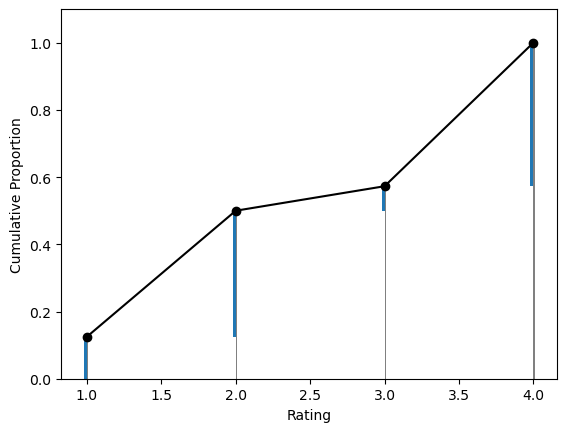

In [5]:
#12M2
x = [1,2,3,4]

plt.plot(x, emp_rating_prop_cusum, '-o', color='black')
plt.bar(x, emp_rating_prop_cusum, width=0.01, color ='grey', align='edge')
plt.bar(x,[emp_rating_prop_cusum[0]] + list(np.diff(emp_rating_prop_cusum)), width=-0.02, bottom=([0] + list(emp_rating_prop_cusum[:-1])),align='edge')
plt.ylim(0,1.1)

plt.ylabel('Cumulative Proportion')
plt.xlabel('Rating')
plt.show()

# 12H1 Question
In 2014, a paper was published that was entitled “Female hurricanes are deadlier than male
hurricanes.”191 As the title suggests, the paper claimed that hurricanes with female names have caused
greater loss of life, and the explanation given is that people unconsciously rate female hurricanes
as less dangerous and so are less likely to evacuate. Statisticians severely criticized the paper after
publication. Here, you’ll explore the complete data used in the paper and consider the hypothesis
that hurricanes with female names are deadlier. Load the data with:

library(rethinking)
data(Hurricanes)

Acquaint yourself with the columns by inspecting the help ?Hurricanes. In this problem, you’ll focus on predicting deaths using femininity of each hurricane’s name. Fit and interpret the simplest
possible model, a Poisson model of deaths using femininity as a predictor. You can use quap or
ulam. Compare the model to an intercept-only Poisson model of deaths. How strong is the association between femininity of name and deaths? Which storms does the model fit (retrodict) well?
Which storms does it fit poorly

In [6]:
hurricanes_data = pd.read_csv('./data/Hurricanes.csv',sep=';')
hurricanes_data.head()

,name,year,deaths,category,min_pressure,damage_norm,female,femininity
0,Easy,1950,2,3,960,1590,1,6.77778
1,King,1950,4,3,955,5350,0,1.38889
2,Able,1952,3,1,985,150,0,3.83333
3,Barbara,1953,1,1,987,58,1,9.83333
4,Florence,1953,0,1,985,15,1,8.33333


In [7]:
def normalize(x):
    return (x - x.mean()) / x.std()

In [8]:
hurricanes_data['femininity_std'] = normalize(hurricanes_data['femininity'])

In [9]:
with pm.Model() as m_12h1:
    a = pm.Normal('a',1,0.5)
    b = pm.Normal('b',0,1) 
    p = pm.Deterministic("p", pm.math.exp(a + b*hurricanes_data['femininity_std']))
    T = pm.Poisson('deaths',p,observed=hurricanes_data['deaths'])
    m_12h1_trace = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_12h1_a:
    a = pm.Normal('a',1,0.5)
    p = pm.Deterministic("p", pm.math.exp(a))
    T = pm.Poisson('deaths',p,observed=hurricanes_data['deaths'])
    m_12h1_a_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [10]:
az.summary(m_12h1_trace, var_names=['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.997,0.024,2.951,3.043,0.0,0.0,3516.0,2943.0,1.0
b,0.239,0.026,0.191,0.286,0.0,0.0,3540.0,2774.0,1.0


In [11]:
az.summary(m_12h1_a_trace, var_names=['a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.023,0.022,2.983,3.065,0.001,0.0,1715.0,2751.0,1.0


In [12]:
compare_12h1 = {
    "Intercept_Only": m_12h1_a_trace, 
    "Femininity": m_12h1_trace}
az.compare(compare_12h1, ic='loo',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: S

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Femininity,0,4381.338136,117.070452,0.000000,0.468159,981.771979,0.000000,True,deviance
Intercept_Only,1,4421.967455,67.298006,40.629319,0.531841,1062.541041,144.107331,True,deviance


Adding Feminity doesn't add much to the intercept model, although it does seem to add a small improvement. The coeffficient is also fairly small, indicating a weaker relationship between feminity and deaths

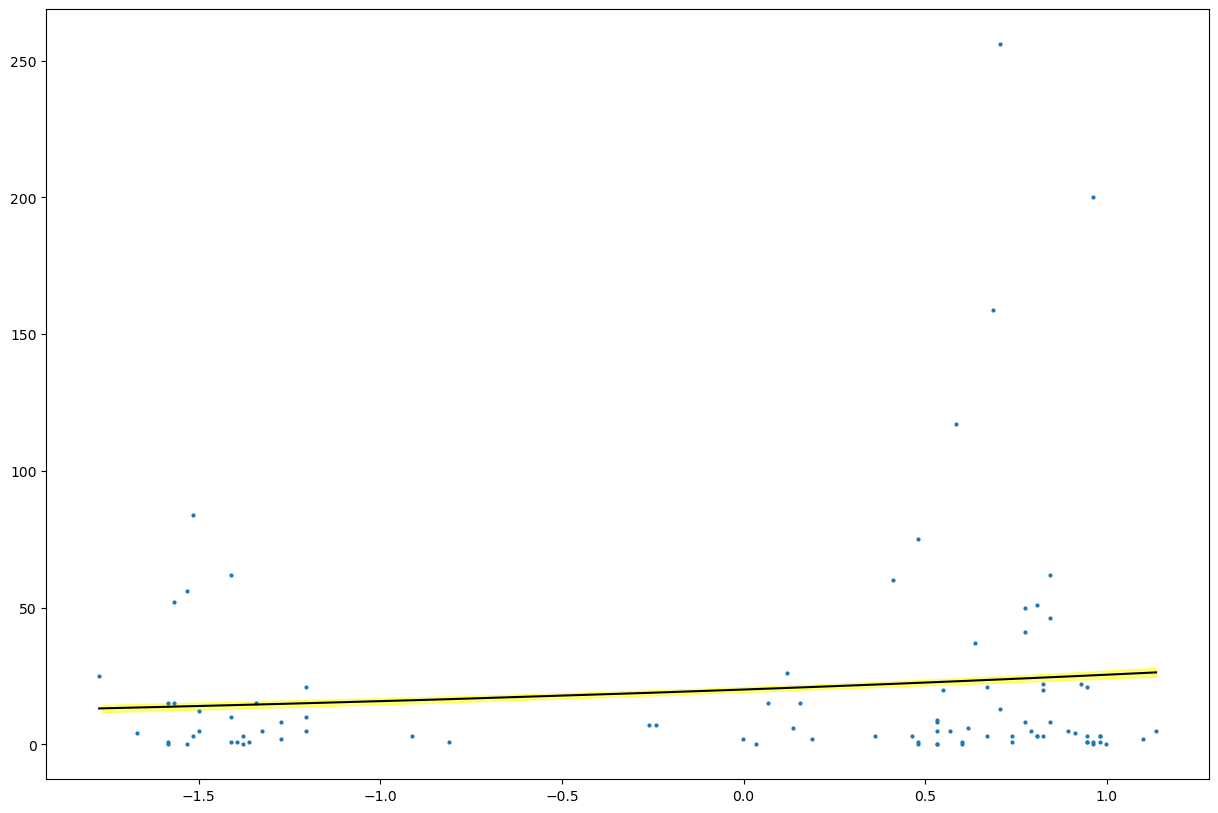

In [13]:
#x_predict = np.linspace(-2,2, 100)
#predictions = np.exp(m12h1_trace['posterior']['a'].mean().values) + x_predict *  np.exp(m12h1_trace['posterior']['b'].mean().values)

sort_order = np.argsort(hurricanes_data['femininity_std'])
plt.figure(figsize=(15,10))
ax = az.plot_hdi(hurricanes_data['femininity_std'], m_12h1_trace.posterior["p"], hdi_prob=.94, color="yellow")
ax.scatter(hurricanes_data['femininity_std'],hurricanes_data['deaths'], s=4)
ax.plot(hurricanes_data['femininity_std'][sort_order], m_12h1_trace['posterior']['p'].mean(['chain','draw']).values[sort_order],color='black')
#plt.plot(x_predict,predictions, color='black',ax=ax)

It's clear that this model isn't really capturing the data at all, even in the prediction interval.  The model is especially bad the more feminine and more masculine the names are

# 12H2 Question
Counts are nearly always over-dispersed relative to Poisson. So fit a gamma-Poisson (aka
negative-binomial) model to predict deaths using femininity. Show that the over-dispersed model
no longer shows as precise a positive association between femininity and deaths, with an 89% interval
that overlaps zero. Can you explain why the association diminished in strength

In [14]:
#12h2
with pm.Model() as m_12h2:
    a = pm.Normal('a',1,0.5)
    b = pm.Normal('b',0,1) 
    phi = pm.Exponential("phi", 1.0)
    p = pm.Deterministic("p", pm.math.exp(a + b*hurricanes_data['femininity_std']))
    T = pm.NegativeBinomial('deaths',p,phi, observed=hurricanes_data['deaths'])
    m_12h2_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [15]:
az.summary(m_12h2_trace,var_names=['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.854,0.139,2.594,3.108,0.002,0.001,5874.0,3351.0,1.0
b,0.215,0.144,-0.050,0.487,0.002,0.002,5210.0,3115.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

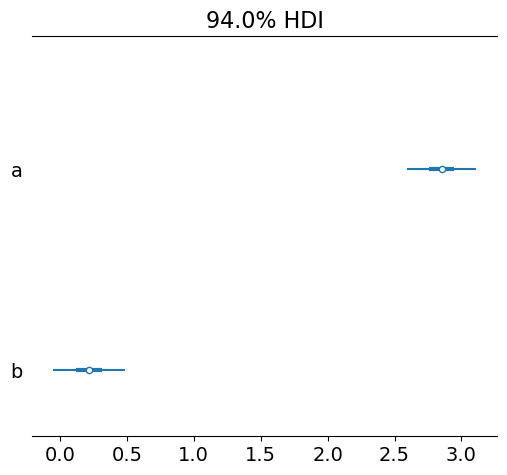

In [16]:
az.plot_forest(m_12h2_trace, var_names=['a','b'], combined=True)

The uncernaity around b (the coefficient for femininity) has increased and overlaps with zero.

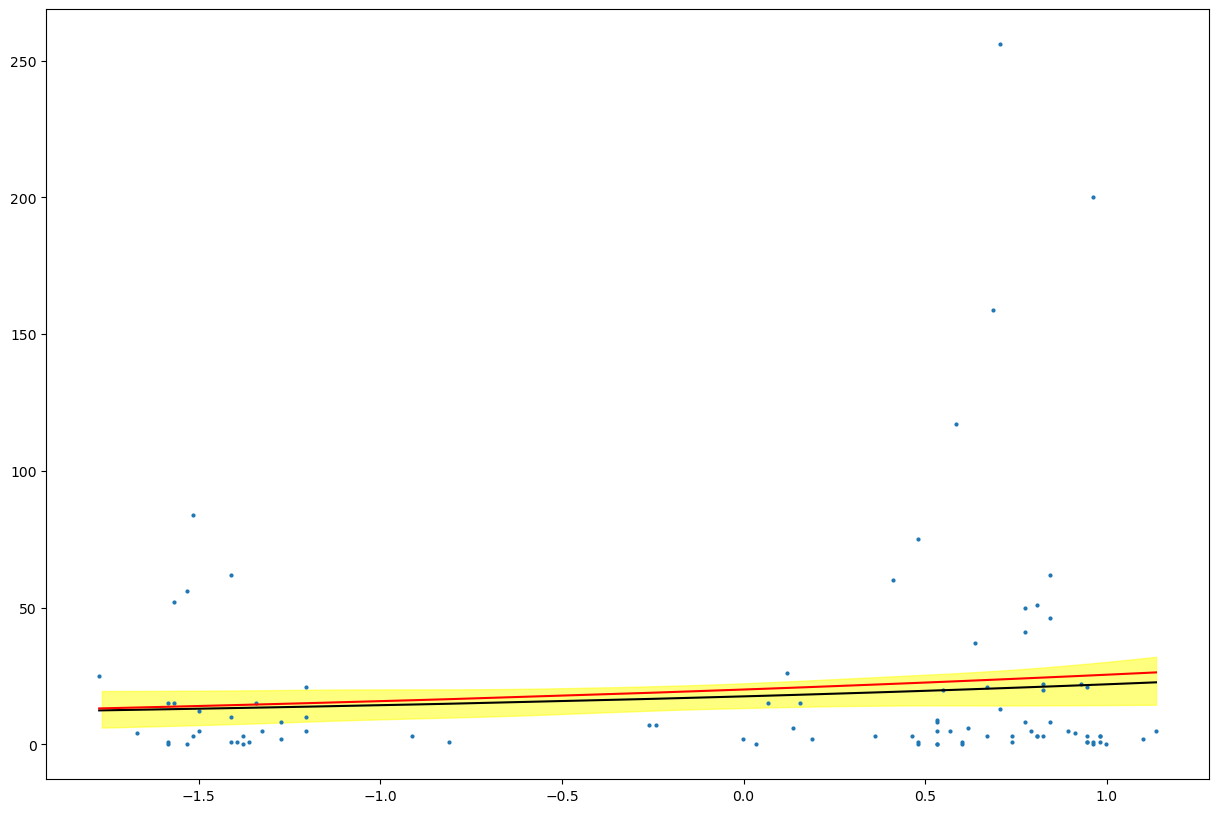

In [17]:
#x_predict = np.linspace(-2,2, 100)
#predictions = np.exp(m12h1_trace['posterior']['a'].mean().values) + x_predict *  np.exp(m12h1_trace['posterior']['b'].mean().values)

sort_order = np.argsort(hurricanes_data['femininity_std'])
plt.figure(figsize=(15,10))
ax = az.plot_hdi(hurricanes_data['femininity_std'], m_12h2_trace.posterior["p"], color="yellow")
ax.scatter(hurricanes_data['femininity_std'],hurricanes_data['deaths'], s=4)
ax.plot(hurricanes_data['femininity_std'][sort_order], m_12h2_trace['posterior']['p'].mean(['chain','draw']).values[sort_order],color='black')
ax.plot(hurricanes_data['femininity_std'][sort_order], m_12h1_trace['posterior']['p'].mean(['chain','draw']).values[sort_order],color='red')
#plt.plot(x_predict,predictions, color='black',ax=ax)

Apart from increasing the uncernaity and pulling more predictions into the hdi_interval, this model is still quite bad.  One immediate challenge is that there are are lot of extreme values at either end of this chart.  One advantage of the Gamma-Possion model is that you can see the effect of the extreme values on the right side of this chart is less pronouced, as black line is not being pulled up like the original Possion model.  As for why, this is because the Gamma-Possion allows the rate to have a distribution across cases, and not assume the same rate for every case.

In [18]:
compare_12h2 = {
    "Intercept_Only": m_12h1_a_trace, 
    "Femininity": m_12h1_trace,
    "Gamma-Poisson": m_12h2_trace}
az.compare(compare_12h2, ic='loo',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: S

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma-Poisson,0,710.553070,3.799551,0.000000,1.000000e+00,34.601964,0.000000,False,deviance
Femininity,1,4381.338136,117.070452,3670.785066,0.000000e+00,981.771979,957.863894,True,deviance
Intercept_Only,2,4421.967455,67.298006,3711.414385,6.369685e-10,1062.541041,1039.184911,True,deviance


In [19]:
az.loo(m_12h1_trace)

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 92 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2190.67   490.89
p_loo      117.07        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       84   91.3%
 (0.5, 0.7]   (ok)          2    2.2%
   (0.7, 1]   (bad)         2    2.2%
   (1, Inf)   (very bad)    4    4.3%

In [20]:
az.loo(m_12h2_trace)

Computed from 4000 posterior samples and 92 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -355.28    17.30
p_loo        3.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       92  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

One benefit of the Gamma-Poisson model is that you can see that the number of highly influencal points is much lower, with no values above 1

# 12H3 Question
In the data, there are two measures of a hurricane’s potential to cause death: damage_norm
and min_pressure. Consult ?Hurricanes for their meanings. It makes some sense to imagine that
femininity of a name matters more when the hurricane is itself deadly. This implies an interaction
between femininity and either or both of damage_norm and min_pressure. Fit a series of models
evaluating these interactions. Interpret and compare the models. In interpreting the estimates, it
may help to generate counterfactual predictions contrasting hurricanes with masculine and feminine
names. Are the effect sizes plausible

In [21]:
#12H3
hurricanes_data['damage_norm_std'] = normalize(hurricanes_data['damage_norm'])
hurricanes_data['min_pressure_std'] = normalize(hurricanes_data['min_pressure'])

In [22]:
#12h3
with pm.Model() as m_12h3_a:
    a = pm.Normal('a',0,1)
    bf = pm.Normal('bf',0,1) 
    bdn = pm.Normal('bdn', 0,1)
    bfdn = pm.Normal('bfdn',0,1)
    alpha = pm.Exponential("alpha", 1)
    femty = pm.MutableData('femty', hurricanes_data['femininity_std'], dims="obs_id")
    dnstd = pm.MutableData('dnstd', hurricanes_data['damage_norm_std'], dims="obs_id")
    p = pm.Deterministic("p", pm.math.exp(a + 
                                          bf*femty + 
                                          bdn*dnstd+  
                                          bfdn*femty*dnstd
                                         )
                        )
    deaths = pm.NegativeBinomial('deaths',mu=p,alpha=alpha, observed=hurricanes_data['deaths'])
    m_12h3_a_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bf, bdn, bfdn, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [23]:
az.summary(m_12h3_a_trace, var_names=['a','bf','bdn','bfdn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.553,0.131,2.295,2.785,0.002,0.002,3680.0,2721.0,1.0
bf,0.087,0.123,-0.145,0.315,0.002,0.002,4284.0,2800.0,1.0
bdn,1.249,0.215,0.843,1.646,0.004,0.003,3734.0,2938.0,1.0
bfdn,0.307,0.204,-0.104,0.661,0.003,0.003,3783.0,2571.0,1.0


We can see that once we add damage norm, feminity goes to zero.  However, there is some effect between the interaction of feminity and damange norm.

In [24]:
dnseq = np.linspace(-1,5,hurricanes_data.shape[0])
with m_12h3_a:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], 1), 'dnstd':dnseq})
    fem_post_pred = pm.sample_posterior_predictive(m_12h3_a_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

with m_12h3_a:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], -1), 'dnstd':dnseq})
    masc_post_pred = pm.sample_posterior_predictive(m_12h3_a_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

Sampling: [deaths]


Sampling: [deaths]


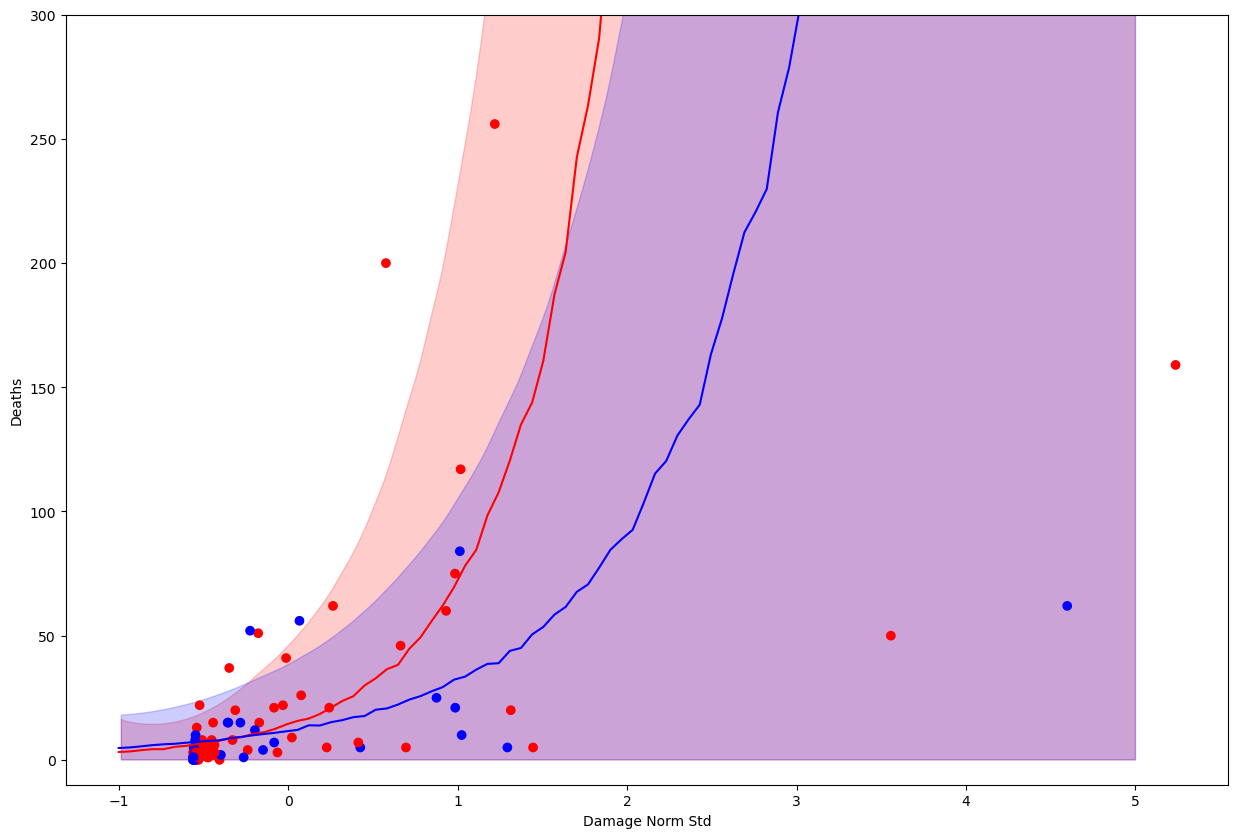

In [25]:
point_colors = hurricanes_data['female'].apply(lambda x: 'red' if x == 1 else 'blue')
plt.figure(figsize=(15,10))
ax = az.plot_hdi(dnseq,fem_post_pred['predictions']['deaths'], color='red',fill_kwargs={"alpha": 0.2})

ax.plot(dnseq,fem_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'red', label = 'Feminine')

az.plot_hdi(dnseq,masc_post_pred['predictions']['deaths'], color='blue',fill_kwargs={"alpha": 0.2}, ax=ax)
ax.plot(dnseq,masc_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'blue', label = 'Masculine')
ax.scatter(hurricanes_data['damage_norm_std'],hurricanes_data['deaths'], color = point_colors)
plt.ylim(-10,300)
plt.ylabel('Deaths')
plt.xlabel('Damage Norm Std')
plt.show()

It looks like there isn't much of a difference as the lower end, but the number of deaths from storms with feminine names rises a lot quicker than masculine names.  But this is likely the result of the storms in the upper left side with very high death numbers.  This helps to explain the interaction as well

In [26]:
#12h3
with pm.Model() as m_12h3_b:
    a = pm.Normal('a',1,1)
    bf = pm.Normal('bf',0,1) 
    bmp = pm.Normal('bmp', 0,1)
    bfmp = pm.Normal('bfmp',0,1)
    alpha = pm.Exponential("alpha", 1)
    femty = pm.MutableData('femty', hurricanes_data['femininity_std'], dims="obs_id")
    mpstd = pm.MutableData('mpstd', hurricanes_data['min_pressure_std'], dims="obs_id")
    p = pm.Deterministic("p", pm.math.exp(a + 
                                          bf*femty + 
                                          bmp*mpstd+  
                                          bfmp*femty*mpstd
                                         )
                        )
    deaths = pm.NegativeBinomial('deaths',mu=p,alpha=alpha, observed=hurricanes_data['deaths'])
    m_12h3_b_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bf, bmp, bfmp, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [27]:
az.summary(m_12h3_b_trace, var_names=['a','bf','bmp','bfmp'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.751,0.142,2.490,3.020,0.002,0.001,4778.0,3091.0,1.0
bf,0.299,0.143,0.045,0.582,0.002,0.002,4410.0,3139.0,1.0
bmp,-0.673,0.138,-0.932,-0.424,0.002,0.001,4251.0,3328.0,1.0
bfmp,0.302,0.146,0.050,0.594,0.002,0.002,3819.0,2995.0,1.0


With min_pressure, feminity has a strong associated with deaths, and there is an interaction.  The min_pressure relationship is strongly negative, which makes sense since lower values indicate stronger storms.

In [28]:
mpseq = np.linspace(-3,2,hurricanes_data.shape[0])
with m_12h3_b:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], 1), 'mpstd':mpseq})
    fem_post_pred = pm.sample_posterior_predictive(m_12h3_b_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

with m_12h3_b:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], -1), 'mpstd':mpseq})
    masc_post_pred = pm.sample_posterior_predictive(m_12h3_b_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

Sampling: [deaths]


Sampling: [deaths]


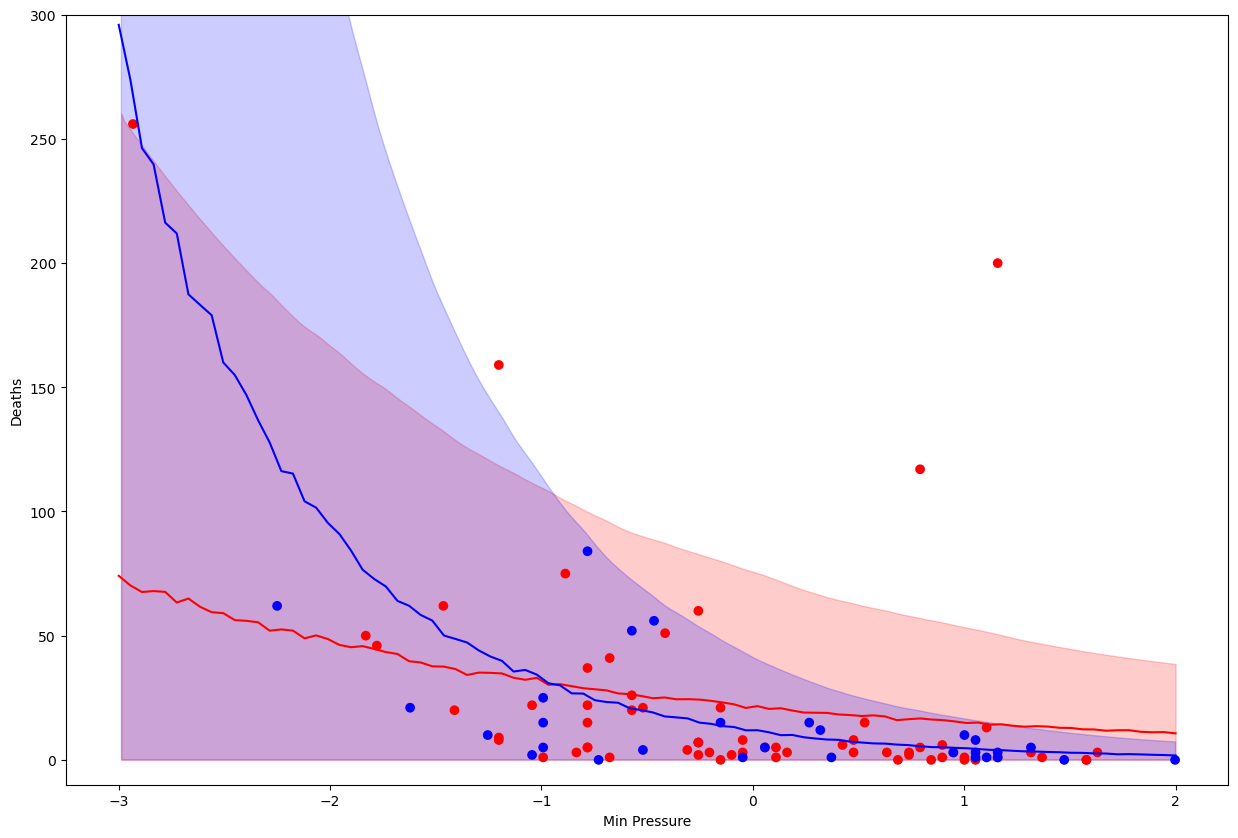

In [29]:
point_colors = hurricanes_data['female'].apply(lambda x: 'red' if x == 1 else 'blue')
plt.figure(figsize=(15,10))
ax = az.plot_hdi(mpseq,fem_post_pred['predictions']['deaths'], color='red',fill_kwargs={"alpha": 0.2})

ax.plot(mpseq,fem_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'red', label = 'Feminine')

az.plot_hdi(mpseq,masc_post_pred['predictions']['deaths'], color='blue',fill_kwargs={"alpha": 0.2}, ax=ax)
ax.plot(mpseq,masc_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'blue', label = 'Masculine')
ax.scatter(hurricanes_data['min_pressure_std'],hurricanes_data['deaths'], color = point_colors)
plt.ylim(-10,300)
plt.ylabel('Deaths')
plt.xlabel('Min Pressure')
plt.show()

The feminine versus masculine trend seems to reverse itself in this.  However, this might be because of the weaker storms with a high number of deathers (on the right hand side) pulling the feminine trend upwards.

#12H4. 
In the original hurricanes paper, storm damage (damage_norm) was used directly. This assumption implies that mortality increases exponentially with a linear increase in storm strength, because a Poisson regression uses a log link. So it’s worth exploring an alternative hypothesis: that the
logarithm of storm strength is what matters. Explore this by using the logarithm of damage_norm as
a predictor. Using the best model structure from the previous problem, compare a model that uses
log(damage_norm) to a model that uses damage_norm directly. Compare their PSIS/WAIC values
as well as their implied predictions. What do you conclude?

In [30]:
hurricanes_data['damage_norm_log_std'] = normalize(np.log(hurricanes_data['damage_norm']))

In [31]:
with pm.Model() as m_12h4:
    a = pm.Normal('a',0,1)
    bf = pm.Normal('bf',0,1) 
    bdn = pm.Normal('bdn', 0,1)
    bfdn = pm.Normal('bfdn',0,1)
    alpha = pm.Exponential("alpha", 1)
    femty = pm.MutableData('femty', hurricanes_data['femininity_std'], dims="obs_id")
    dnlstd = pm.MutableData('dnlstd', hurricanes_data['damage_norm_log_std'], dims="obs_id")
    p = pm.Deterministic("p", pm.math.exp(a + 
                                          bf*femty + 
                                          bdn*dnlstd+  
                                          bfdn*femty*dnlstd
                                         )
                        )
    deaths = pm.NegativeBinomial('deaths',mu=p,alpha=alpha, observed=hurricanes_data['deaths'])
    m_12h4_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bf, bdn, bfdn, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [32]:
compare_12h4 = {
    "Damage Norm": m_12h3_a_trace, 
    "Damange Norm Log": m_12h4_trace}
az.compare(compare_12h2, ic='loo',scale='deviance')

d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
d:\Python\venv\pymc_env\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: S

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma-Poisson,0,710.553070,3.799551,0.000000,1.000000e+00,34.601964,0.000000,False,deviance
Femininity,1,4381.338136,117.070452,3670.785066,0.000000e+00,981.771979,957.863894,True,deviance
Intercept_Only,2,4421.967455,67.298006,3711.414385,6.369685e-10,1062.541041,1039.184911,True,deviance


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

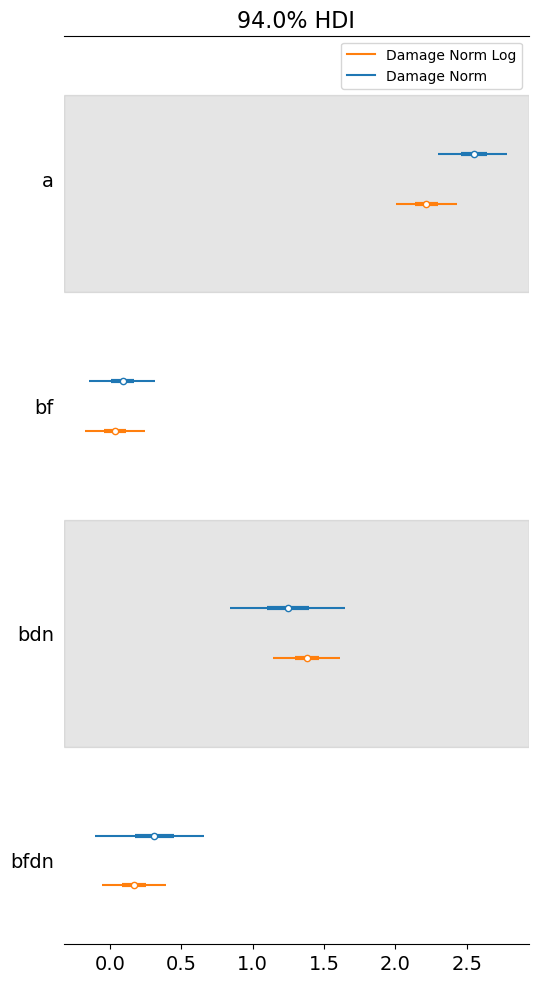

In [33]:
az.plot_forest([m_12h3_a_trace,m_12h4_trace], model_names=['Damage Norm', 'Damage Norm Log'],var_names=['a','bf','bdn','bfdn'], combined=True)

The log model is performing better than just the Damage Norm, but it does look like the interval for each coeffient has grown as well. But all of the coeffiients do overlap to a large degree

In [34]:
dnseq = np.linspace(-3,2,hurricanes_data.shape[0])
with m_12h4:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], 1), 'dnlstd':dnseq})
    fem_post_pred = pm.sample_posterior_predictive(m_12h4_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

with m_12h4:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], -1), 'dnlstd':dnseq})
    masc_post_pred = pm.sample_posterior_predictive(m_12h4_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

Sampling: [deaths]


Sampling: [deaths]


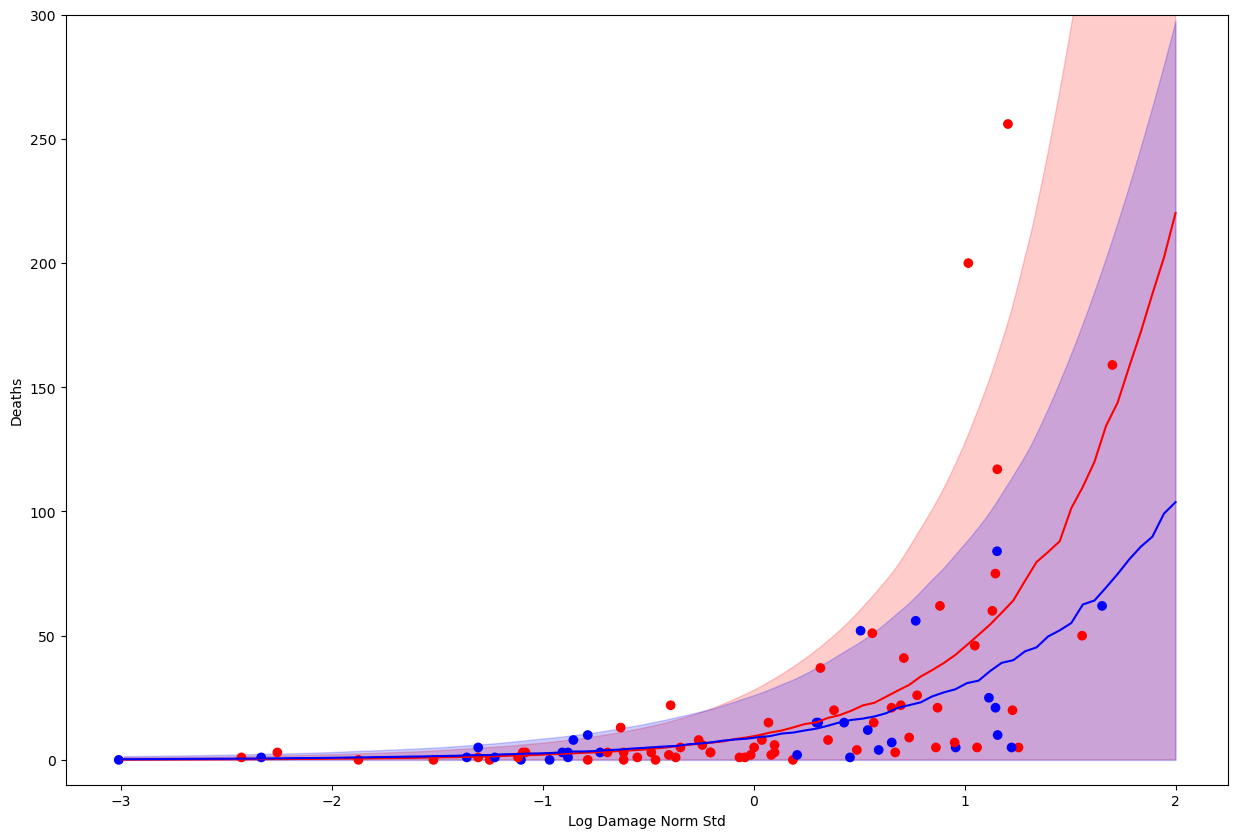

In [35]:
point_colors = hurricanes_data['female'].apply(lambda x: 'red' if x == 1 else 'blue')
plt.figure(figsize=(15,10))
ax = az.plot_hdi(dnseq,fem_post_pred['predictions']['deaths'], color='red',fill_kwargs={"alpha": 0.2})

ax.plot(dnseq,fem_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'red', label = 'Feminine')

az.plot_hdi(dnseq,masc_post_pred['predictions']['deaths'], color='blue',fill_kwargs={"alpha": 0.2}, ax=ax)
ax.plot(dnseq,masc_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'blue', label = 'Masculine')
ax.scatter(hurricanes_data['damage_norm_log_std'],hurricanes_data['deaths'], color = point_colors)
plt.ylim(-10,300)
plt.ylabel('Deaths')
plt.xlabel('Log Damage Norm Std')
plt.show()

Now it looks like the model fits the data a lot better.  It still looks like a few extreme values (where the deaths > 100) are pulling the feminine trend higher faster on the right hand side.

In [36]:
#one of the things that looks odd to me are the intervals with the Gamma-Poisson models.  They are just incredibly wide and I couldn't
#figure out if this is just the way things because of the data, or if there's a bug in how the intervals are being calculated.  
# Trying a regular poisson just for the sake of it.
with pm.Model() as m_12h4_p:
    a = pm.Normal('a',0,1)
    bf = pm.Normal('bf',0,1) 
    bdn = pm.Normal('bdn', 0,1)
    bfdn = pm.Normal('bfdn',0,1)
    alpha = pm.Exponential("alpha", 1)
    femty = pm.MutableData('femty', hurricanes_data['femininity_std'], dims="obs_id")
    dnlstd = pm.MutableData('dnlstd', hurricanes_data['damage_norm_log_std'], dims="obs_id")
    p = pm.Deterministic("p", pm.math.exp(a + 
                                          bf*femty + 
                                          bdn*dnlstd+  
                                          bfdn*femty*dnlstd
                                         )
                        )
    deaths = pm.Poisson('deaths',mu=p, observed=hurricanes_data['deaths'])
    m_12h4_p_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bf, bdn, bfdn, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [37]:
dnseq = np.linspace(-3,2,hurricanes_data.shape[0])
with m_12h4_p:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], 1), 'dnlstd':dnseq})
    fem_post_pred = pm.sample_posterior_predictive(m_12h4_p_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

with m_12h4_p:
    pm.set_data({'femty':np.full(hurricanes_data.shape[0], -1), 'dnlstd':dnseq})
    masc_post_pred = pm.sample_posterior_predictive(m_12h4_p_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

Sampling: [deaths]


Sampling: [deaths]


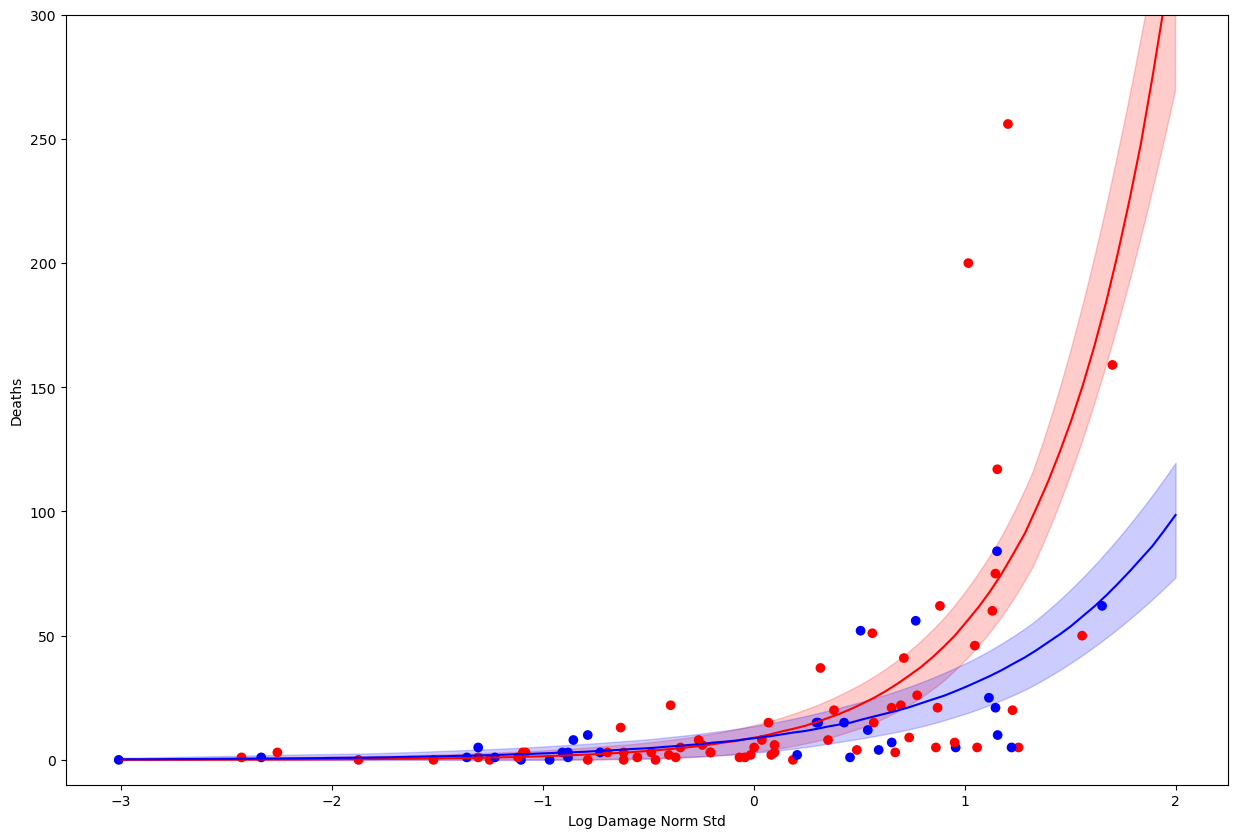

In [38]:
point_colors = hurricanes_data['female'].apply(lambda x: 'red' if x == 1 else 'blue')
plt.figure(figsize=(15,10))
ax = az.plot_hdi(dnseq,fem_post_pred['predictions']['deaths'], color='red',fill_kwargs={"alpha": 0.2})

ax.plot(dnseq,fem_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'red', label = 'Feminine')

az.plot_hdi(dnseq,masc_post_pred['predictions']['deaths'], color='blue',fill_kwargs={"alpha": 0.2}, ax=ax)
ax.plot(dnseq,masc_post_pred['predictions']['deaths'].mean(['chain','draw']).values, color = 'blue', label = 'Masculine')
ax.scatter(hurricanes_data['damage_norm_log_std'],hurricanes_data['deaths'], color = point_colors)
plt.ylim(-10,300)
plt.ylabel('Deaths')
plt.xlabel('Log Damage Norm Std')
plt.show()

Moving to Poisson shrinks the intervals considerably.

# 12H5 Question

One hypothesis from developmental psychology, usually attributed to Carol Gilligan, proposes that women and men have different average tendencies in moral reasoning. Like most hypotheses in social psychology, it is descriptive, not causal. The notion is that women are more concerned with care (avoiding harm), while men are more concerned with justice and rights. Evaluate this hypothesis, using the Trolley data, supposing that contact provides a proxy for physical harm. Are
women more or less bothered by contact than are men, in these data? Figure out the model(s) that is
needed to address this question.

In [39]:
trolley_data = pd.read_csv('./data/Trolley.csv', sep = ';')
trolley_data.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


In [40]:
trolley_data['response_adj'] = trolley_data['response'] - 1
gid = trolley_data['male']

with pm.Model() as m_12h5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=6,
        initval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5, shape=2)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5, shape=2)

    Action = pm.Data("action", trolley_data['action'])
    Intention = pm.Data("intention", trolley_data['intention'])
    Contact = pm.Data("contact", trolley_data['contact'])

    BI = bI + bIA * Action + bIC[gid] * Contact
    phi = pm.Deterministic("phi", bA * Action + bC[gid] * Contact + BI * Intention)

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=trolley_data['response_adj'])

    m_12h5_trace = pm.sample()

d:\Python\venv\pymc_env\lib\site-packages\pymc\distributions\transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
d:\Python\venv\pymc_env\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bC, bI, bIA, bIC]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 201 seconds.


In [41]:
az.summary(m_12h5_trace, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bIC[0],-1.10,0.13,-1.34,-0.87,0.0,0.0,3724.50,3081.00,1.0
bIC[1],-1.29,0.12,-1.52,-1.08,0.0,0.0,3382.89,3206.77,1.0
bIA,-0.43,0.08,-0.58,-0.28,0.0,0.0,3187.72,3360.19,1.0
bC[0],-0.62,0.09,-0.78,-0.45,0.0,0.0,3522.73,3166.88,1.0
bC[1],-0.13,0.08,-0.29,0.02,0.0,0.0,3533.36,2702.87,1.0
bI,-0.30,0.06,-0.41,-0.20,0.0,0.0,3048.33,3193.64,1.0
bA,-0.48,0.05,-0.58,-0.38,0.0,0.0,3062.65,2988.51,1.0


If we look at BC, we can see that women are more bothered by contact.  But it reverses itself in the interaction between contact and interaction , which is a stronger predictor than just contact.

# 12H6 Question
The data in data(Fish) are records of visits to a national park. See ?Fish for details. The
question of interest is how many fish an average visitor takes per hour, when fishing. The problem is
that not everyone tried to fish, so the fish_caught numbers are zero-inflated. As with the monks
example in the chapter, there is a process that determines who is fishing (working) and another process that determines fish per hour (manuscripts per day), conditional on fishing (working). We want
to model both. Otherwise we’ll end up with an underestimate of rate of fish extraction from the park.
You will model these data using zero-inflated Poisson GLMs. Predict fish_caught as a function
of any of the other variables you think are relevant. One thing you must do, however, is use a proper
Poisson offset/exposure in the Poisson portion of the zero-inflated model. Then use the hours variable to construct the offset. This will adjust the model for the differing amount of time individuals
spent in the park.

In [42]:
fish_data = pd.read_csv('./data/Fish.csv',sep=';')
fish_data

,fish_caught,livebait,camper,persons,child,hours
0,0,0,0,1,0,21.124
1,0,1,1,1,0,5.732
2,0,1,0,1,0,1.323
3,0,1,1,2,1,0.548
4,1,1,0,1,0,1.695
...,...,...,...,...,...,...
245,0,1,1,2,0,10.219
246,0,1,1,4,3,0.004
247,0,1,1,2,1,1.969
248,0,1,1,3,2,0.075


In [43]:
fish_data['hours_log'] = np.log(fish_data['hours'])

In [44]:
#My logic here is that if you are a camper and if you have children will determine the probability of if you go fishing.  I assume camper increases the probability of fishing because
#you are there for more time.  And having kids with you will generally decrease the probability of fishing, because they want do to active things, not sitting around in a boat for hours
with pm.Model() as m_12h6:
    a0 = pm.Normal('a0',0,1)
    a1 = pm.Normal('a1',0,1)
    bcamp =  pm.Normal("bcamp", 0, 1)
    bchild = pm.Normal("bchild", 0, 1)
    bbait = pm.Normal('bbait',0,1)
    bpersons = pm.Normal('bpersons',0,1)
    bhours = pm.Normal('bhours',0,1)

    persons = pm.MutableData("persons", fish_data['persons'], dims="obs_id")
    hours = pm.MutableData("hours", fish_data['hours_log'], dims="obs_id")
    child = pm.MutableData("child", fish_data['child'], dims="obs_id")
    camper = pm.MutableData("camper", fish_data['camper'], dims="obs_id")
    livebait = pm.MutableData("livebait", fish_data['livebait'], dims="obs_id")

    p = pm.Deterministic("p",pm.math.invlogit(a0 + bcamp * camper + bchild * child),dims="obs_id")
    lambda_ = pm.Deterministic("lambda_",pm.math.exp(a1 + bbait * livebait + bpersons * persons + bhours*hours),dims="obs_id")

    caught = pm.ZeroInflatedPoisson("caught", p,lambda_, observed=fish_data['fish_caught'],dims="obs_id")

    m_12h6_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, a1, bcamp, bchild, bbait, bpersons, bhours]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


In [45]:
az.summary(m_12h6_trace, var_names=['a0','a1','bcamp','bchild','bbait','bpersons','bhours'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a0,0.672,0.316,0.103,1.277,0.006,0.005,2763.0,2408.0,1.0
a1,-2.524,0.261,-3.023,-2.044,0.005,0.004,2364.0,2591.0,1.0
bcamp,0.789,0.353,0.162,1.500,0.006,0.005,3481.0,2512.0,1.0
bchild,-1.441,0.265,-1.933,-0.952,0.005,0.003,3331.0,2107.0,1.0
bbait,1.505,0.218,1.127,1.927,0.004,0.003,2827.0,2372.0,1.0
bpersons,0.817,0.043,0.736,0.896,0.001,0.001,3287.0,2647.0,1.0
bhours,0.334,0.027,0.283,0.385,0.000,0.000,4056.0,2854.0,1.0


Genally speaking, people won't catch fish (a1).  As expected, camping increases the fish caught, and number of kids decreases it.  Live bait increases the number, and more people fishing means more fish caught as well.

In [46]:
def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))
    
prop_fishing = inv_logit(m_12h6_trace['posterior']['a0'].mean().values)
print(f'Probability of Fishing {round(prop_fishing,2)}')
#TBH I'm nots sure if the output means they are 66% not likely to fish, or 66% likely to fish 

Probability of Fishing 0.66


In [47]:
#Average Number of Fish caught - basically zero
typ_avg_fish_caught = np.exp(m_12h6_trace['posterior']['a1'].mean().values)
print(f'Average Number of Fish caught {round(typ_avg_fish_caught,2)}')

Average Number of Fish caught 0.08


In [48]:
with m_12h6:
    pm.set_data({'persons':[1,1],
                 'hours':[np.log(1),np.log(1)],
                 'child':[0,0],
                 'camper':[0,0],
                 'livebait':[0,1]}
                 )
    m_12h6_post_pred = pm.sample_posterior_predictive(m_12h6_trace,
                                                   return_inferencedata=True,
                                                   predictions=True)

Sampling: [caught]


In [49]:
#Predicted Number of Fish caught in 1 hour by 1 person
m_12h6_post_pred['predictions']['caught'][:,:,0].mean().values

array(0.126)

In [50]:
#Predicted Number of Fish caught in 1 hour by 1 person with live bait.  Using live bait does increase things by quite a bit
m_12h6_post_pred['predictions']['caught'][:,:,1].mean().values

array(0.53125)

# 12H7 Question
In the trolley data—data(Trolley)—we saw how education level (modeled as an ordered
category) is associated with responses. But is this association causal? One plausible confound is that
education is also associated with age, through a causal process: People are older when they finish
school than when they begin it. Reconsider the Trolley data in this light. Draw a DAG that represents hypothetical causal relationships among response, education, and age. Which statical model or
models do you need to evaluate the causal influence of education on responses? Fit these models to
the trolley data. What do you conclude about the causal relationships among these three variables?


In [51]:
#12h7
trolley_data = pd.read_csv("./data/Trolley.csv", sep=";")
trolley_data.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


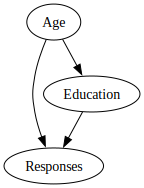

In [52]:
trolley_age = CausalGraphicalModel(
    nodes=["Responses","Age","Education"],
    edges=[
        ("Age", "Education"),
        ("Age", "Responses"),
        ("Education", "Responses")
    ]
)
trolley_age.draw()

In [53]:
trolley_data["edu_new"] = pd.Categorical(
    trolley_data.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_data["edu_new"] = trolley_data.edu_new.cat.codes

In [54]:
R = trolley_data.response.values - 1
A = trolley_data.action.values
I = trolley_data.intention.values
C = trolley_data.contact.values
E = trolley_data.edu_new.values
AGE = normalize(trolley_data['age'])


In [55]:
with pm.Model() as m_12h7:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)
    bAge = pm.Normal("bAge", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cumulative = pt.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I + bAge * AGE

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    m_12h7_trace = pm.sample()

d:\Python\venv\pymc_env\lib\site-packages\pymc\distributions\transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
C:\Users\ukamath\AppData\Local\Temp\ipykernel_29744\3750799152.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  kappa = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, bA, bC, bI, bE, bAge, delta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 420 seconds.


In [56]:
az.summary(m_12h7_trace,var_names=["bA", "bC", "bI", "bE","bAge","delta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.701,0.041,-0.779,-0.625,0.001,0.001,3096.0,2478.0,1.0
bC,-0.951,0.049,-1.039,-0.853,0.001,0.001,3192.0,2812.0,1.0
bI,-0.715,0.036,-0.781,-0.646,0.001,0.000,3575.0,3083.0,1.0
bE,0.229,0.103,0.051,0.416,0.004,0.003,1365.0,552.0,1.0
bAge,-0.098,0.021,-0.137,-0.060,0.000,0.000,2192.0,1572.0,1.0
delta[0],0.110,0.072,0.002,0.239,0.001,0.001,3152.0,2358.0,1.0
delta[1],0.119,0.077,0.003,0.258,0.001,0.001,3270.0,2120.0,1.0
delta[2],0.087,0.060,0.003,0.197,0.001,0.001,2654.0,2290.0,1.0
delta[3],0.066,0.054,0.002,0.157,0.001,0.001,2493.0,1717.0,1.0
delta[4],0.438,0.138,0.146,0.684,0.004,0.003,1367.0,558.0,1.0


If you compare this to the model (in the book) without Age, you'll notice that while all the other b* coefficients are mostly the same, bE has gone from negative to positive.  So now more educated people disapprove less.  However, the older you are, the more you disapprove of things.  So obviously both Age and Education are interacting to influence the reponses

# 12H8 Question
Consider one more variable in the trolley data: Gender. Suppose that gender might influence
education as well as response directly. Draw the DAG now that includes response, education, age, and
gender. Using only the DAG, is it possible that the inferences from 12H7 above are confounded by
gender? If so, define any additional models you need to infer the causal influence of education on
response. What do you conclude

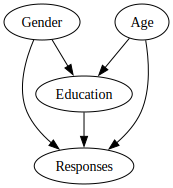

In [57]:
trolley_age = CausalGraphicalModel(
    nodes=["Responses","Age","Education","Gender"],
    edges=[
        ("Age", "Education"),
        ("Age", "Responses"),
        ("Gender","Education"),
        ("Education", "Responses"),
        ("Gender","Responses")
    ]
)
trolley_age.draw()

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

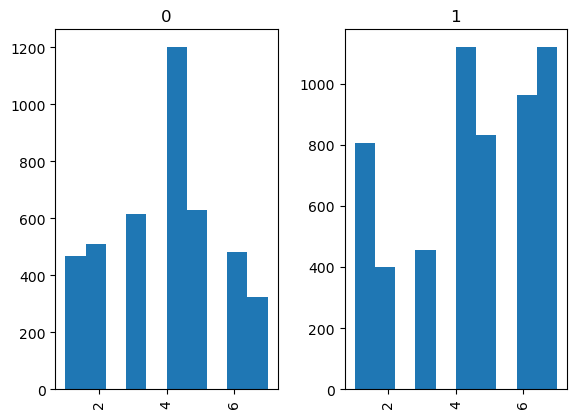

In [58]:
#Looking at simple histograms, we can see there are some differences between men and women.
trolley_data.hist('response', by = 'male')

In [59]:
gid = trolley_data['male']

In [60]:
with pm.Model() as m_12h8:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5, shape=2)
    bAge = pm.Normal("bAge", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cumulative = pt.cumsum(delta_j)

    phi = bE[gid] * delta_j_cumulative[E] + bA * A + bC * C + bI * I + bAge * AGE

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    m_12h8_trace = pm.sample()

d:\Python\venv\pymc_env\lib\site-packages\pymc\distributions\transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
C:\Users\ukamath\AppData\Local\Temp\ipykernel_29744\2162002943.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  kappa = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, bA, bC, bI, bE, bAge, delta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 412 seconds.


In [61]:
az.summary(m_12h8_trace, var_names=["bA", "bC", "bI", "bE","bAge","delta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.704,0.040,-0.782,-0.629,0.001,0.000,3950.0,3029.0,1.0
bC,-0.959,0.050,-1.056,-0.869,0.001,0.001,3762.0,3034.0,1.0
bI,-0.722,0.036,-0.792,-0.659,0.001,0.000,3409.0,2701.0,1.0
bE[0],-0.561,0.123,-0.783,-0.316,0.003,0.002,1672.0,2044.0,1.0
bE[1],0.192,0.132,-0.055,0.445,0.003,0.002,1606.0,1757.0,1.0
bAge,-0.065,0.020,-0.103,-0.028,0.000,0.000,3046.0,2556.0,1.0
delta[0],0.175,0.098,0.016,0.348,0.002,0.001,3252.0,2065.0,1.0
delta[1],0.149,0.089,0.010,0.315,0.001,0.001,3148.0,2343.0,1.0
delta[2],0.246,0.115,0.045,0.459,0.002,0.001,3026.0,2131.0,1.0
delta[3],0.109,0.065,0.004,0.224,0.001,0.001,2863.0,2038.0,1.0


Interestingly enough, bAge moves much closer to zero when we include Gender.  And you can see in bE that as education rises, females disapprove more.  But it's the opposite for men, where as educational attainment rises, the males disapprove less.